# Rice Image Classification - CNN
Stephanie

# Imports

In [63]:

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.utils import Sequence

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

from PIL import Image

# drive
# from google.colab import drive

random.seed(2)


In [ ]:
# only needed if running in colab
# drive.mount('/content/drive', force_remount=True)

## Data Ingestion

Let's take a look at what each grain of rice looks like. Here we will look at the first image in each folder. The Each folder is a different class, or a different type of rice grain. There are 5 types of rice (Arborio, Basmati, Ipsala, Jasmine and Karacdag )

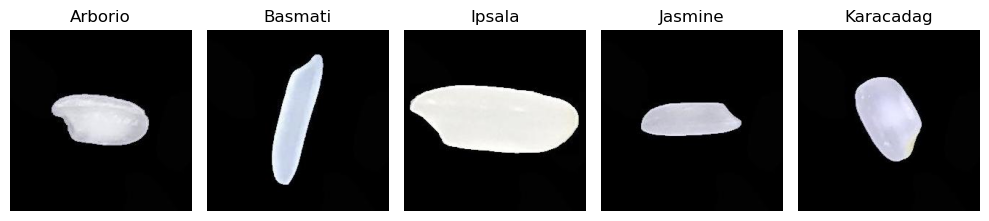

In [49]:
# show images of rice
root_dir = './Rice_Image_Dataset/' # running locally
# root_dir = '/content/drive/MyDrive/DATASCI207/207-final_project/Rice_Image_Dataset/' # running in colab

# rice_class = ['Basmati', 'Jasmine', 'Arborio', 'Ipsala', 'Karacadag']
rice_class = sorted(os.listdir(root_dir))


plt.figure(figsize=(10,20))
i = 0

for sub_dir in rice_class:
    class_path = os.path.join(root_dir, sub_dir)

    if not os.path.isdir(class_path):
        continue

    image_files = sorted(os.listdir(class_path))

    first_image = os.path.join(class_path, image_files[0])

    show_image = mpimg.imread(first_image)

    plt.subplot(10, 5, i + 1)
    plt.imshow(show_image)
    plt.title(sub_dir)
    plt.axis("off")  # Hide axes
    i += 1

plt.tight_layout()
plt.show()


#### Import image and label
We need to label the images based on what directory they are in. Here we make a dataframe with the filename its corresponding label. To make image loading easier, we will also include the file path, and to make the labels more interpretable by the model we will enumerate the labels.

In [50]:
# store filename and label
label_data = []

# Get list of labels and enumerate
labels = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
label_to_idx = {label: idx for idx, label in enumerate(labels)}

# print label mapping
print(label_to_idx)

# make dataframe to label image names
for label in os.listdir(root_dir):
    label_path = os.path.join(root_dir, label)

    if os.path.isdir(label_path):
        for filename in os.listdir(label_path):
            if filename.lower().endswith('.jpg'):
                label_data.append({'filename': os.path.join(filename),
                                   'filepath': os.path.join(label_path, filename),
                                   'label': label_to_idx[label],
                                   'label_name': label})

df_label = pd.DataFrame(label_data)

df_label

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


,filename,filepath,label,label_name
0,Karacadag (12521).jpg,./Rice_Image_Dataset/Karacadag/Karacadag (1252...,4,Karacadag
1,Karacadag (1341).jpg,./Rice_Image_Dataset/Karacadag/Karacadag (1341...,4,Karacadag
2,Karacadag (6484).jpg,./Rice_Image_Dataset/Karacadag/Karacadag (6484...,4,Karacadag
3,Karacadag (9771).jpg,./Rice_Image_Dataset/Karacadag/Karacadag (9771...,4,Karacadag
4,Karacadag (8863).jpg,./Rice_Image_Dataset/Karacadag/Karacadag (8863...,4,Karacadag
...,...,...,...,...
74995,Jasmine (5558).jpg,./Rice_Image_Dataset/Jasmine/Jasmine (5558).jpg,3,Jasmine
74996,Jasmine (13104).jpg,./Rice_Image_Dataset/Jasmine/Jasmine (13104).jpg,3,Jasmine
74997,Jasmine (9982).jpg,./Rice_Image_Dataset/Jasmine/Jasmine (9982).jpg,3,Jasmine
74998,Jasmine (11139).jpg,./Rice_Image_Dataset/Jasmine/Jasmine (11139).jpg,3,Jasmine


## Image Dataset: Exploratory Data Analysis

Check if the classes are balanced by graphing a histogram of the number of images for each rice type.

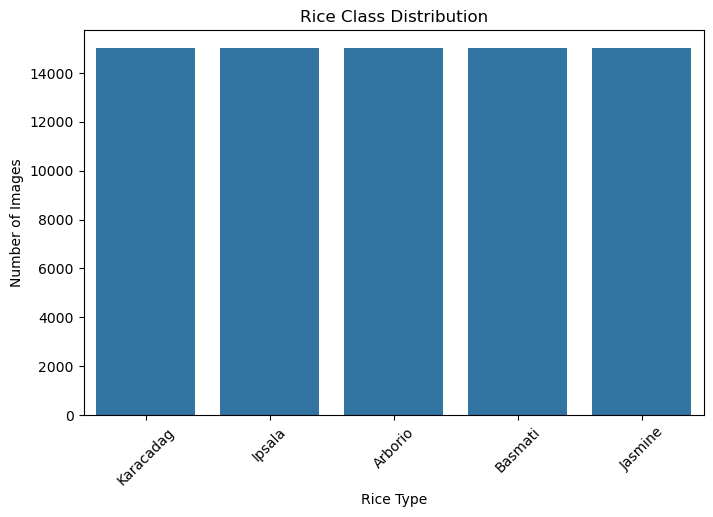

In [103]:
plt.figure(figsize=(8,5))
sns.countplot(x='label_name', data=df_label)
plt.title('Rice Class Distribution')
plt.xlabel('Rice Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

Preprocessing <br>
- Normalize pixels
- Image resizing, augmentation (implement if needed) 


Using the keras utility `image_dataset_from_directory` to:
- Load images
- Train - Validation - Test split [60-20-20]
- Shuffle dataset
- Apply preprocessing

In [52]:
def preprocess(image, label):

    # normalize pixels
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = image / 255.0  # Rescale pixel values to 0-1

    # other preprocessing opportunities (image resizing, augmentation)


    return image, label

In [53]:
image_size = (250, 250)  # Adjust to your desired image size
batch_size = 32

full_ds = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123 # ensures consistency
)

# Get total number of samples and calculate splits
total_samples = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = int(0.2 * total_samples)

# Split the data into train, validation, and test sets
train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

Found 75000 files belonging to 5 classes.


### Run in Colab

In [ ]:
# run in colab

image_size = (250, 250)  # Adjust to your desired image size
batch_size = 32

with tf.device('/GPU:0'):

  full_ds = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123 # ensures consistency 
  )

# Get total number of samples and calculate splits
total_samples = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = int(0.2 * total_samples)

# Split the data into train, validation, and test sets
train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

## Define Model

In [100]:
num_classes = 5

# Define the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.AveragePooling2D(pool_size=(2, 2), strides=2),
    # layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    # layers.GlobalAveragePooling2D(),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train model

In [81]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss') # val_loss is the validation/test data
    plt.xlabel('Epoch')
    plt.xticks(range(len(history.history['loss'])))
    plt.ylabel('Loss')
    plt.title('Convolutional Neural Network: Loss')
    plt.legend()
    plt.grid(False)
    plt.show()

In [84]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy') # val_loss is the validation/test data
    plt.xlabel('Epoch')
    plt.xticks(range(len(history.history['accuracy'])))
    plt.ylabel('Accuracy')
    plt.title('Convolutional Neural Network: Accuracy')
    plt.legend()
    plt.grid(False)
    plt.show()

Epoch 1/5


1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1365s 970ms/step - accuracy: 0.9038 - loss: 9.1693 - val_accuracy: 0.9717 - val_loss: 0.0857
Epoch 2/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1270s 904ms/step - accuracy: 0.9799 - loss: 0.0626 - val_accuracy: 0.9761 - val_loss: 0.0957
Epoch 3/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1238s 881ms/step - accuracy: 0.9830 - loss: 0.0565 - val_accuracy: 0.9742 - val_loss: 0.1072
Epoch 4/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1241s 883ms/step - accuracy: 0.9884 - loss: 0.0329 - val_accuracy: 0.9787 - val_loss: 0.1000
Epoch 5/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1264s 899ms/step - accuracy: 0.9928 - loss: 0.0206 - val_accuracy: 0.9752 - val_loss: 0.1268
470/470 ━━━━━━━━━━━━━━━━━━━━ 117s 232ms/step - accuracy: 0.9778 - loss: 0.1204
Test accuracy: 0.9790446758270264


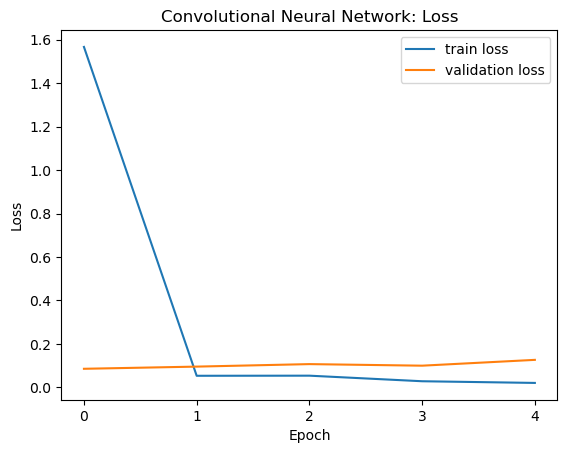

In [101]:
# Train the model
epochs = 5

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy)

plot_loss(history)

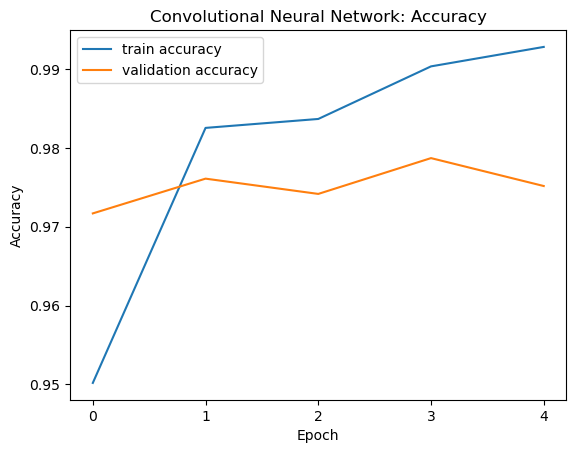

In [102]:
plot_accuracy(history)

#### Confusion Matrix
Where is the model inaccurate? Use the results to inform how to run the next model.

In [106]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-04-16 21:57:19.379656: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [107]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

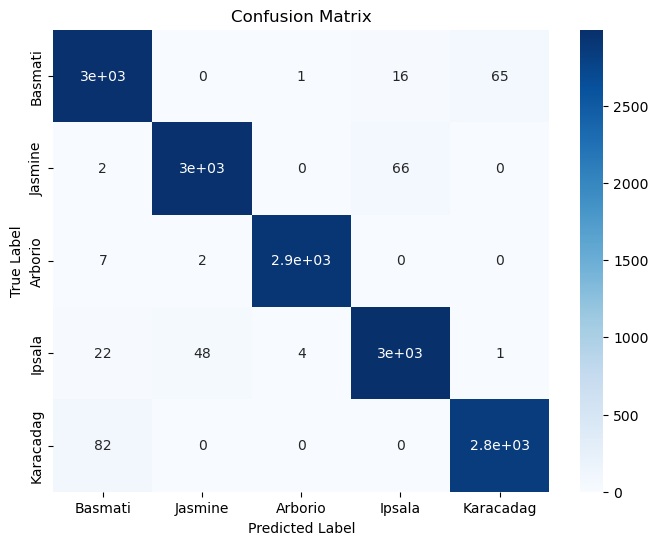

In [110]:
# Plot confusion matrix

rice_labels = ['Basmati', 'Jasmine', 'Arborio', 'Ipsala', 'Karacadag']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=rice_labels, yticklabels=rice_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Ablation Study

| Test Number | Number of Layers | Number of Epochs | Pooling Method | Training Accuracy | Validation Accuracy | Test Accuracy |
|-------------|------------------|------------------|----------------|-------------------|----------------------|---------------|
| 1           | 1                | 5                | Max Pooling    | 99.42%             | 97.39%                | 97.35%         |
| 2           | 2                | 5                | MAx Pooling    | 99.02%             | 97.57%                | 97.64%         |
| 3           | 2                | 10               | Max Pooling    | 99.48%             | 96.84%                | 96.86%         |
| 4           | 3                | 5                | Max Pooling    | 99.88%             | 97.94%                | 98.19%         |
| 5           | 3                | 10               | Max Pooling    | 99.36%             | 97.14%                | 97.03%         |
| 6           | 2                | 5                | Avg Pooling    | 99.28%             | 97.52%                | 97.90%         |
| 7           | 2                | 10               | Global Avg Pooling    | 98.29%             | 94.50%                | 94.49%         |
